In [14]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_scheduler
from tqdm.notebook import tqdm


In [15]:
df = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
df = df[['description', 'type']].dropna()

# Binary labels: Movie=1, TV Show=0
df['label'] = df['type'].apply(lambda x: 1 if x == 'Movie' else 0)

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['description'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)


In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
class NetflixDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = NetflixDataset(train_encodings, train_labels)
val_dataset = NetflixDataset(val_encodings, val_labels)


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                             num_training_steps=num_training_steps)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
model.train()

for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())


  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

In [22]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)
        
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

print(classification_report(true_labels, predictions, target_names=['TV Show', 'Movie']))


              precision    recall  f1-score   support

     TV Show       0.72      0.61      0.67       548
       Movie       0.84      0.89      0.86      1214

    accuracy                           0.81      1762
   macro avg       0.78      0.75      0.77      1762
weighted avg       0.80      0.81      0.80      1762



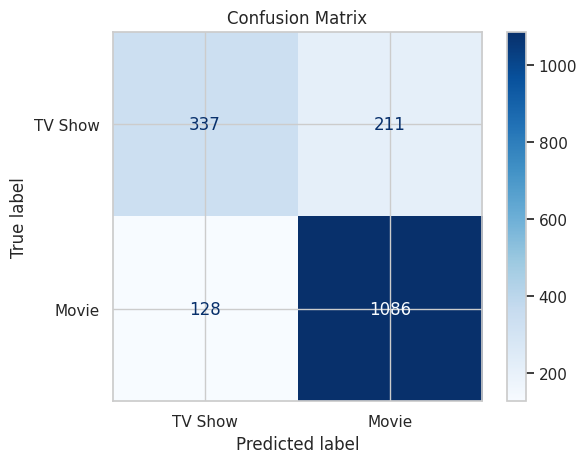

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['TV Show', 'Movie'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [24]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [25]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss(weight=class_weights)

outputs = model(**batch)
loss = loss_fn(outputs.logits, batch['labels'])
